Source - https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

This cheat sheet demonstrates 11 different classical time series forecasting methods; they are:

Autoregression (AR)

Moving Average (MA)

Autoregressive Moving Average (ARMA)

Autoregressive Integrated Moving Average (ARIMA)

Seasonal Autoregressive Integrated Moving-Average (SARIMA)

Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors (SARIMAX)

Vector Autoregression (VAR)

Vector Autoregression Moving-Average (VARMA)

Vector Autoregression Moving-Average with Exogenous Regressors (VARMAX)

Simple Exponential Smoothing (SES)

Holt Winter’s Exponential Smoothing (HWES)

### Autoregression

The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps.

The stronger the correlation between the output variable and a specific lagged variable, the more weight that autoregression model can put on that variable when modeling. Again, because the correlation is calculated between the variable and itself at previous time steps, it is called an autocorrelation

**Assumptions** - Observations at previous time steps are useful to predict the value at the next time step.



In [1]:
# AR example
from statsmodels.tsa.ar_model import AR
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
model = AR(data)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

[100.72685298]


       date  temperature
0  1/1/1981         20.7
1  1/2/1981         17.9
2  1/3/1981         18.8
3  1/4/1981         14.6
4  1/5/1981         15.8


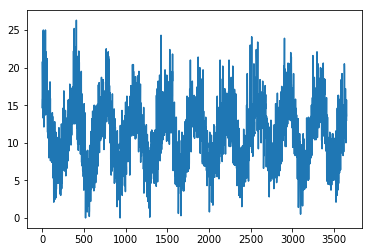

In [48]:
import pandas as pd
from matplotlib import pyplot
df_auto = pd.read_csv('daily-minimum-temperatures.csv')
df_auto.columns = ['date', 'temperature']
df_auto['temperature'].plot()
print(df_auto.head())

C:\Users\bandi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  


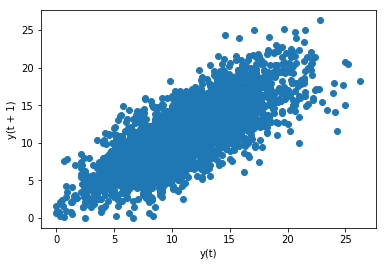

In [45]:
from pandas.tools.plotting import lag_plot
lag_plot(df_auto['temperature'])

## Auto correlation plots

The plot provides the lag number along the x-axis and the correlation coefficient value between -1 and 1 on the y-axis. The plot also includes solid and dashed lines that indicate the 95% and 99% confidence interval for the correlation values. Correlation values above these lines are more significant than those below the line, providing a threshold or cutoff for selecting more relevant lag values.

C:\Users\bandi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  


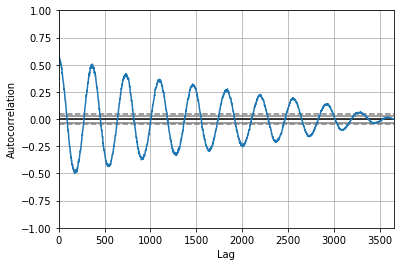

In [46]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(df_auto['temperature'])

In [52]:
# create lagged dataset
values = pd.DataFrame(df_auto['temperature'].values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']

We will first create a persistence model, where we will predict temperatures from the last day temperatures

In [54]:
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

Test MSE: 3.423


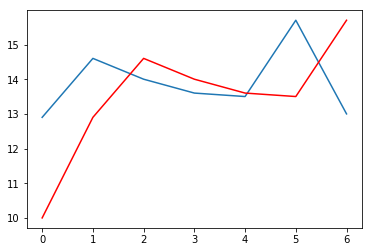

In [57]:
from sklearn.metrics import mean_squared_error

# persistence model
def model_persistence(x):
    return x
 
# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
    
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()

Now we will run the autoregression model. One way to run this model is to create a lag variable and run regression on it. However, a better way is to use statsmodels package and import AR (Auto Regression)

In [59]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
X = df_auto['temperature'].values

Lag: 29
Coefficients: [ 5.57543506e-01  5.88595221e-01 -9.08257090e-02  4.82615092e-02
  4.00650265e-02  3.93020055e-02  2.59463738e-02  4.46675960e-02
  1.27681498e-02  3.74362239e-02 -8.11700276e-04  4.79081949e-03
  1.84731397e-02  2.68908418e-02  5.75906178e-04  2.48096415e-02
  7.40316579e-03  9.91622149e-03  3.41599123e-02 -9.11961877e-03
  2.42127561e-02  1.87870751e-02  1.21841870e-02 -1.85534575e-02
 -1.77162867e-03  1.67319894e-02  1.97615668e-02  9.83245087e-03
  6.22710723e-03 -1.37732255e-03]
Test MSE: 1.502


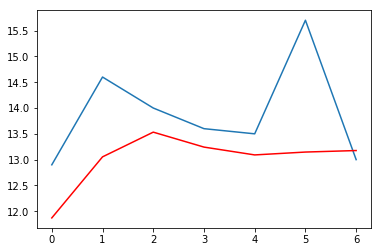

In [73]:
train , test = X[1:len(X)-7], X[len(X)-7:len(X)]
# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
test_score = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()

### Moving Average (MA)

Rather than using past values of the forecast variable in a regression, a moving average model uses past forecast errors in a regression-like model.

This method is useful for univariate time series (i.e. sequence of measurements of the same variable over time) without trend and seasonal variations

**Note** - This is different from MA smoothing. MA smoothing is used to eatimate the trend cycle of the past values. But MA model is used for forecasting

In [74]:
# MA example
from statsmodels.tsa.arima_model import ARMA
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model. No AR, 1st order MA
model = ARMA(data, order=(0, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

[75.06920525]


### ARIMA - AutoRegressive Integrated Moving Averages
 - 
 Let's first see some key terminologies 
 
1. **Stationary Time Series** - One which does not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. On the other hand, a white noise series is stationary — it does not matter when you observe it, it should look much the same at any point in time. In general, a stationary time series will have no predictable patterns in the long-term.

2. **Differencing** - One  way to make a non-stationary time series stationary — compute the differences between consecutive observations. This is known as differencing. Transformations such as logarithms can help to stabilise the variance of a time series. Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality.

**Note** - We can also look at auto correlation function (ACF) plots. The ACF plots for non-stationary series drop slowly to zero, while those of stationary series will drop quickly! 

3. **Second order differencing** - Occasionally the differenced data will not appear to be stationary and it may be necessary to difference the data a second time to obtain a stationary series:

    y1(t) = y(t) - y(t-1)
    
    y1(t) = (y(t) - y(t-1)) - (y(t-1) - y(t-2))
    
    
4. **Backshift Notation** - 

    B(Byt) = B<sup>2</sup>y<sub>t</sub> = y<sub>t−2</sub>
    
    
In general, a dth-order difference can be written as:
    
(1-B)<sup>d</sup>y<sub>t
    
**Thus, if we combine auto-regression, differencing and moving averages we obtain a non-seasonal ARIMA. Integrated is basically the reverse of differencing**.

    y′t=c+ϕ1y′t−1+⋯+ϕpy′t−p+θ1εt−1+⋯+θqεt−q+εt, where where y't is the differenced series


Alright, now that we have seen the math behind the model, let's see how to implement it. In Python we use ARIMA(p,d,q) function. We need to specify the value of p,d,q 

In [75]:
from statsmodels.tsa.arima_model import ARIMA
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
model = ARIMA(data, order=(1, 1, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data), len(data), typ='levels')
print(yhat)

[100.42299174]


### Steps Invoved in ARIMA Modeling?

1. **EDA** - Overview of whether data has seasonality or non-stationary, changing variance, etc.


2. **Transformation** - We can stabilize the variance by the box cox transformation (To obtain normal distrivution of constant variance. Say if we apply a logarithmic transformation, then difference between smaller values could be increased, while for larger values reduced. Increasing distance of left tail and reducing on right tail will make a right skewed distribution to ND.)

The Box-Cox power transformation searches from Lambda = -5 to Lamba = +5 until the best value is found to convert into ND. Some other transformation need to apply.

3. **Check for non-stationary data** - check by plotting or some statistical tests. If non-stationary data, then take differencing. **NOTE - Random Walk is a non-stationary time series**.


4. **Examine ACF and PACF plots to find the order of ARIMA terms (p,q,d)** - We can find the optimal order using some standard metrics (AIC). Least AIC scores will mean good predictions. These should be in a way that we get high accuracy of the predictions. 


5. **Check for residuals** - Even if we are getting good accuracy, we need to plot the residuals. They should be white noise, i.e. Mean = 0 and Constant std. deviation. If this is not the case, i.e. there is some pattern in the residual it means we are missing some information in our predictions. Maybe sometime you might have to increase d to say 3rd differentiation. Keep on trying higher p and q.


6. **Forecast**

### What are the ways to determine the order of ARIMA terms (p,q,d)

- ACF/PACF
- Model Fit 
- Parsimony (AIC/BIC)


 - ACF/PACF:
 
a.) # of differentiations - The # of times we need to take the differences to make the time seies data stationary

b.) It is usually not possible to tell, simply from a time plot, what values of p  and  q  are appropriate for the data. However, it is sometimes possible to use the ACF (Auto Correlation function) plot, and the closely related PACF (Partial Auto Correlation function) plot, to determine appropriate values for p and q.

**PACF** - Its also called conditional correlation. Say you have yt and y(t-s). Simple correlation = Correl(yt , y(t - s))

Partial correlation = Take control of all intermediate values (series). So y(t-1), y(t-2).....y(t-s+1)

So, Correl (yt, y(t-s)| y(t-1), y(t-2).....y(t-s+1))


By looking at the PACF function it becmes very clear at what lag value is the PACF value dropping suddenly.

So Geometric decay for ACF for AR and significant till p lags for MA
And Significant till p lags  for PACF for AR and geometric decay for MA

Further the decay rate helps in determing the value of the coeffieceint. If decay rate is higher then then coefficient value is lower. 


 - **Model fit**: Now we calculate the value of p,q and d on a standalone basis. i.e. p and q ae not deterined based on how many diferentiation is done. So, join p, q is found out by the model fitness! Then fine tune the p,q values to see where we get lesser error and a better fit
 
 
  - **Parsimony (AIC/BIC)** - Lesser the AIC/BIC, it is a better model. Parsimonius, means a model with lesser number of terms! So, if ARIMA (1,1,1) and ARIMA (2,1,1) have same accuracy, then ARIMA (1,1,1) is better
  
  Trade off - Adding extra terms vs penalty. So, AIC/BIC penalizes for extra terms (Overfitting). AIC is faster than cross validation
  
  **AIC=−2logL+2p**, where p is the # of parameters. AIC can take many parameters if the data size is smaller. So to take care of smaller data sizes, AICc is used
  
  **BIC=−2logL+plog(n)**, where n is the # of observations used. BIC has a higher penalty of log (n) to the # of parameters. So, BIC is either equal or lesser than AIC 
  
  BIC is an estimate of a function of the posterior probability of a model being true
  
  **Note** - AIC/AICc/BIC is used for selecting the appropriate order for p,q and not d. Changing d (differencing) will change the data on which likelihood is computed, making AIC values between models with diff orders of differencing not comparable. 
 


### How to validate ARIMA?

 - Preiction accuracy - In sample and out sample (like any other model)
 - Diagnostic checks for Residuals

### Some Questions for Interviews


 - Time Series is supervised in nature
 - Random Walk is Non-stationary Model. Stationarity is a property of a time series data, where stat measures like mean, variance, auto-corel does not change over time
 - Is Time Series Sensitive to Outliers - YES!!! 
 

### SES (Simple Exponential Smoothing)

The Simple Exponential Smoothing (SES) method models the next time step as an exponentially weighted linear function of observations at prior time steps.

SmoothedForecast_t=α×(Actual_(t-1) )+(1-α)×(Forecast_(t-1) )

We need to choose alpha and initialization. All values can be computed once we know these. We estimate these coefficients by minimizing the SSE and puting constraints on alpha that it has to be between 0-1

**Note** - SES excldes seasonality and trend

In [77]:
# SES example
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
model = SimpleExpSmoothing(data)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

[99.15528679]


### Holt Winters' Seasonal Method

Also called the Triple Exponential Smoothing method models the next time step as an exponentially weighted linear function of observations at prior time steps, taking trends and seasonality into account.

In [86]:
# HWES example
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
model = ExponentialSmoothing(data)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

[99.96404575]
